In [1]:
#Import stuff
%matplotlib notebook
from bokeh.plotting import figure, show, output_notebook
# from bokeh.charts import Scatter, output_file, show
# from bkcharts import Scatter, output_file, show
from bokeh.palettes import Spectral6
from bokeh.layouts import gridplot, row, column
from bokeh.models import (
    HoverTool, BoxSelectTool, 
    LassoSelectTool, Spacer, 
    CustomJS, ColumnDataSource, 
    LinearColorMapper, BasicTicker,
    LogColorMapper,
    PrintfTickFormatter,ColorBar
)
from bokeh.models.widgets import Panel, Tabs

import pandas as pd
import matplotlib
import numpy as np 
import matplotlib.pyplot as plt
#print "Numpy version: %s" % np.version.version


### Overview

- [Actin DCA using PFAM families](#Actin-DCA-using-PFAM-Families)
    - [Comparing cluster filtered data with unfiltered data](#Comparing-cluster-filtered-data-with-unfiltered-data)
    - [Comparing mfDCA to plmDCA](#Comparing-mfDCA-to-plmDCA)
- [Actin DCA using HMMER search](#Actin-DCA-from-HMMER-search)
    - [Actin x2 Domain](#Actin-x2-Domain)
    - [Actin Mixed with MreB and Actin x2](#Actin-Mixed-with-MreB-and-Actin-x2)
- [PPV Calculation mfDCA vs. plmDCA](#PPV-Calculation-mfDCA-vs.-plmDCA)
- [Actin SASA DCA contacts](#Solvent-Accessible-Surface-Area-Actin-DCA-contacts)
- [Actin DCA Distance Map from PFAM](#Actin-DCA-Distance-Map-from-PFAM)
- [Homologous Actin DCA](#Homologous-Actin-DCA)
    - [HSP70 DCA](#HSP70-DCA)
    - [MreB DCA](#MreB-DCA)

## Load PDB files

In [2]:
#Files for PDB contacts
pdb_monomer = "./sbm/pdb_maps_8A/cutoff/all_pdb_monomer_8A.contacts"
pdb_interface = "./sbm/pdb_maps_8A/cutoff/all_pdb_interface_8A.contacts"

#Load PDB contacts
pdb_mon_pair_i, pdb_mon_pair_j = np.loadtxt(pdb_monomer, unpack=True)
pdb_inter_pair_i, pdb_inter_pair_j = np.loadtxt(pdb_interface, unpack=True)


# Actin DCA using PFAM Families

[Back to Overview](#Overview)

In [3]:
rel_entropy = './actin-sequences/pfam-MSA/relative_entropy_ssp.txt'
df = pd.DataFrame.from_csv(rel_entropy, sep='\t')
residue_num = list(df.index)
residue_letter = list(df.Letters[0:20])

df2 = df[df.Height > 0.05]
source2 = ColumnDataSource(df2)


In [4]:

# h1 = figure(title="Distribution",tools="save",
#             background_fill_color="#E8DDCB")

# hist, edges = np.histogram(list(df.Height[df.Height > 0.5]), density=True, bins=61)

# h1.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
#         fill_color="#036564", line_color="#033649")

# h1.legend.location = "center_right"
# h1.legend.background_fill_color = "darkgrey"
# h1.xaxis.axis_label = 'x'
# h1.yaxis.axis_label = 'Pr(x)'
# output_notebook()
# show(h1)

[Back to Overview](#Overview)

In [5]:
#Filename for DCA contacts
plmDCA_pfam_file = "./plmDCA/actinf150_mapped_plm.fn"
# plmDCA_pfam_file = "./plmDCA/dca12A_inter_pfam.contacts"

#Load DCA pairs and DI or FN
plm_pair_i, plm_pair_j = np.loadtxt(plmDCA_pfam_file, usecols=(0,1), unpack=True)

#Plots
N=1000
source1 = ColumnDataSource(data=dict(i=plm_pair_i[0:N], j=plm_pair_j[0:N]))
TOOLS="crosshair,pan,wheel_zoom,reset,save,box_select"

code1 = "source1.set('selected', cb_data['index']);"
code2 = "source2.set('selected', cb_data['index']);"
callback = CustomJS(args={'source1': source1, 'source2': source2}, code=code1+code2)

# colors = ["#75968f", "#e2e2e2", "#ddb7b1", "#cc7878", "#933b41", "#550b1d"]
colors = Spectral6
mapper = LogColorMapper(palette=colors, low=df2.Height.min(), high=df2.Height.max())

p3 = figure(title=("Top %d Actin DCA pairs (from Pfam)" % N),
            x_range=(1,375), y_range=(1,375),
            width=700, plot_height=750,  tools=[TOOLS], toolbar_location='above')
s2 = figure(plot_width=300, plot_height=750, 
            x_range=list(reversed(residue_letter)), y_range=p3.y_range, 
            x_axis_location='above', y_axis_location='right', 
            title='Residue Entropy')

color_bar = ColorBar(color_mapper=mapper, major_label_text_font_size="9pt",
            ticker=BasicTicker(desired_num_ticks=len(colors)),
            formatter=PrintfTickFormatter(format="%.2f"), height=25,
            major_label_text_color='black', major_tick_line_color=None,
            major_label_text_align = 'left',
            label_standoff=0, border_line_color=None, location=(0, 0),
            orientation='horizontal')

s2.add_layout(color_bar, 'below')
s2.background_fill_color = "grey"
s2.background_fill_alpha = 0.6
s2.grid.grid_line_color = None
p3.background_fill_color = "beige"
p3.background_fill_alpha = 0.2
p3.grid.grid_line_color = None
p3.xaxis.major_label_orientation = np.pi/3

p3.square(pdb_mon_pair_i, pdb_mon_pair_j, 
          legend="Actin PDB Monomer", color="navy")
p3.scatter(pdb_inter_pair_i, pdb_inter_pair_j,
           legend="Actin PDB Interface", color="orange", alpha=0.5)
p3.square(pdb_mon_pair_j, pdb_mon_pair_i, 
          legend="Actin PDB Monomer", color="navy")
p3.scatter(pdb_inter_pair_j, pdb_inter_pair_i,
           legend="Actin PDB Interface", color="orange", alpha=0.5)
c1 = p3.scatter(x='i',y='j', source=source1, legend="Actin DCA", color="firebrick", alpha=0.8)
# c2 = p3.scatter(x='j',y='i', source=source1, legend="Actin DCA", color="firebrick", alpha=0.8)

#p3.scatter(plm2_pair_i[0:M], plm2_pair_j[0:M], legend="Actin DCA cf", color="lime", alpha=0.4)
s2.xaxis.major_label_orientation = -np.pi / 3
cr = s2.rect(x='Letters', y='Residues', source=source2, width=1, height=3,
               fill_color={'field': 'Height', 'transform': mapper},
               hover_fill_color="firebrick", hover_alpha=0.8,
               line_color='black', line_width=0.4,
               hover_line_color="white")

hover = HoverTool(callback=callback, renderers=[c1, cr], tooltips=[    
    ("Res i, Res j", "$x{0}, $y{0}")])
hover2 = HoverTool(callback=callback, renderers=[cr, c1], tooltips = [
    ('Residue', '@Letters @Residues'),
    ('Probability', '@P_ss{1.111}'),
    ('Information (bits)', '@Height{1.11}'),
])
p3.add_tools(hover)
s2.add_tools(hover2)

p3.legend.location='bottom_center'
g = gridplot([[p3,s2]])


output_notebook()
show(g)

Loading BokehJS ...

## Comparing cluster filtered data with unfiltered data

[Back to Overview](#Overview)

In [56]:
#Files for loading
# plmDCA_file = "./plmDCA/actinf150_mapped_plm.fn"     #6338 Sequences
plmDCA_file2 = "./plmDCA/cluster_filtered/cf2_actinf150_top2kdimer_plm.txt"
plmDCA_file = "./plmDCA/cytoplasm/actin_single_domain/ranked.fn"
#Load DCA pairs and DI or FN
plm_pair_i, plm_pair_j = np.loadtxt(plmDCA_file, usecols=(0,1), unpack=True)
plm2_pair_i, plm2_pair_j = np.loadtxt(plmDCA_file2, usecols=(0,1), unpack=True)

N = 1000   #di for mf is 0.03
TOOLS="crosshair,pan,wheel_zoom,reset,save,box_select, hover"
p1 = figure(title=("Top %d Actin DCA (from Pfam)" % N), 
            width=700, plot_height=500, tools=TOOLS)
p1.scatter(pdb_mon_pair_i, pdb_mon_pair_j, legend="Actin PDB Monomer")
p1.scatter(pdb_inter_pair_i, pdb_inter_pair_j, legend="Actin PDB Interface", color="orange")
p1.scatter(plm_pair_i[0:N], plm_pair_j[0:N], legend="Actin DCA", color="firebrick")
p1.legend.location="bottom_right"
tab00 = Panel(child=p1, title="no filter")

M = 250
p2 = figure(title=("Top %d Cluster-Filtered Actin non-mon DCA (from Pfam)" % M), 
            width=700, plot_height=500, tools=TOOLS)
p2.square(pdb_mon_pair_i, pdb_mon_pair_j, legend="Actin PDB Monomer")
p2.square(pdb_inter_pair_i, pdb_inter_pair_j, legend="Actin PDB Interface", color="orange")
p2.scatter(plm2_pair_i[0:M], plm2_pair_j[0:M], legend="Actin DCA cf", color="firebrick")
p2.legend.location="bottom_right"
tab0 = Panel(child=p2, title="c-filter")

tabs = Tabs(tabs=[ tab00, tab0 ])
# p = gridplot([[p1, p2]], toolbar_location=None)
output_notebook()
show(tabs)

Loading BokehJS ...

## Comparing mfDCA to plmDCA

[Back to Overview](#Overview)

In [49]:
#Files for loading
plmDCA_file = "./plmDCA/actinf150_mapped_plm.fn"
mfDCA_file = "./mfDCA/actin_mapped.di"
#Load DCA pairs and DI or FN
plm_pair_i, plm_pair_j = np.loadtxt(plmDCA_file, usecols=(0,1), unpack=True)
mf_pair_i, mf_pair_j = np.loadtxt(mfDCA_file, usecols=(0,1), unpack=True)

N = 1000  #di for mf is 0.03
hover = HoverTool(tooltips=[("Res i, Res j", "$x{0}, $y{0}")])
TOOLS="crosshair,pan,wheel_zoom,reset,save,box_select"
p15 = figure(title=("Top %d Actin DCA (from Pfam)" % N), 
             width=700, plot_height=500, tools=[TOOLS,hover])
p15.scatter(pdb_mon_pair_i, pdb_mon_pair_j, 
            legend="Actin PDB Monomer")
p15.scatter(pdb_inter_pair_i, pdb_inter_pair_j, 
            legend="Actin PDB Interface", color="orange")
p15.scatter(plm_pair_i[0:N], plm_pair_j[0:N], 
            legend="plmDCA", color="firebrick")
p15.legend.location="bottom_right"
tab1 = Panel(child=p15, title="plmDCA")

M = N
hover2 = HoverTool(tooltips=[("Res i, Res j", "$x{0}, $y{0}")])
p25 = figure(title=("Top %d Actin DCA (from Pfam)" % M), 
             width=700, plot_height=500, tools=[TOOLS,hover2])
p25.square(pdb_mon_pair_i, pdb_mon_pair_j, 
           legend="Actin PDB Monomer")
p25.square(pdb_inter_pair_i, pdb_inter_pair_j, 
           legend="Actin PDB Interface", color="orange")
p25.scatter(mf_pair_i[0:M], mf_pair_j[0:M], 
            legend="mfDCA", color="firebrick")
p25.legend.location="bottom_right"
tab2 = Panel(child=p25, title="mfDCA")

tabs = Tabs(tabs=[ tab1, tab2 ])
# p = gridplot([[p15, p25]], toolbar_location=None)
output_notebook()
show(tabs)

Loading BokehJS ...

# Actin DCA from HMMER search

[Back to Overview](#Overview)

## Actin x2 Domain

[Back to Overview](#Overview)

In [73]:
# actin_actin_DCA_file = "./plmDCA/cytoplasm/from_actin-actin_subseq/dca12A_inter_actin2.contacts" #3071 Sequences
# actin_all_file = "./plmDCA/cytoplasm/actin-mixed/i3/ranked.fn"
actin_actin_DCA_file = "./plmDCA/cytoplasm/from_actin-actin_subseq/cyt_ranked_plm.fn"
# actin_actin_DCA_file = "./plmDCA/cytoplasm/actin_single_domain/actin-single_mapped2cyt.fn"

plmDCA_pfam_file = "./plmDCA/cytoplasm/from_actin-actin_subseq/actinx2_09-25-17/actx2_ranked.fn"
# plmDCA_pfam_file = "./plmDCA/actinf150_mapped_plm.fn"
# plmDCA_pfam_file = "./plmDCA/cytoplasm/from_actin-actin_subseq/ranked_subactx2.fn"

#Load DCA pairs and DI or FN
plm_pair_i, plm_pair_j = np.loadtxt(plmDCA_pfam_file, usecols=(0,1), unpack=True)
#Load DCA pairs and DI
aa_pair_i, aa_pair_j = np.loadtxt(actin_actin_DCA_file, usecols=(0,1), unpack=True)
# aa_pair_i, aa_pair_j = np.loadtxt(actin_all_file, usecols=(0,1), unpack=True)

#Plots
N = 1000
M = N
hover = HoverTool(tooltips=[("Res i, Res j", "$x{0}, $y{0}")])
TOOLS="crosshair,pan,wheel_zoom,reset,save,box_select"
p4 = figure(title=("Top %d DCA pairs using Actin-Actin domain from HMMER" % N),
            width=846, plot_height=600, tools=[TOOLS, hover], 
            x_range=(1,414), y_range=(1,414))
p4.background_fill_color = "beige"
p4.background_fill_alpha = 0.5
p4.square(pdb_mon_pair_i, pdb_mon_pair_j, 
          legend="Actin PDB Monomer", color="navy")
p4.scatter(pdb_inter_pair_i, pdb_inter_pair_j, 
          legend="Actin PDB Interface", color="orange")
p4.scatter(aa_pair_i[0:N], aa_pair_j[0:N], 
          legend="Actinx2 DCA", color="red", alpha=0.9)
p4.scatter(plm_pair_i[0:M], plm_pair_j[0:M], 
          legend="pfam DCA", color="green", alpha=0.5)
p4.legend.location="bottom_right"
p4.legend.click_policy="hide"
output_notebook()
show(p4)

Loading BokehJS ...

## Actin Mixed with MreB and Actin x2

[Back to Overview](#Overview)

In [54]:
actin_mreb = "./plmDCA/actin_mreb/actin_mreb_f100_mapped.fn"
actin_mreb2 = "./plmDCA/actin_mreb/actin_mreb_f200_mapped.fn"
pair_i, pair_j, fn = np.loadtxt(actin_mreb, unpack=True)
pair2_i, pair2_j, fn = np.loadtxt(actin_mreb2, unpack=True)
N = 1500
hover = HoverTool(tooltips=[("Res i, Res j", "$x{0}, $y{0}")])
TOOLS="crosshair,pan,wheel_zoom,reset,save,box_select"
p7 = figure(title=("Top %d Actin+MreB DCA pairs" % N), 
            width=700, plot_height=500, tools=[TOOLS, hover])
p7.background_fill_color = "beige"
p7.background_fill_alpha = 0.5
p7.square(pdb_mon_pair_i, pdb_mon_pair_j, 
          legend="Actin PDB Monomer")
p7.square(pdb_inter_pair_i, pdb_inter_pair_j, 
          legend="Actin PDB Interface", color="orange")
p7.scatter(pair_i[0:N], pair_j[0:N], 
           legend="Actin+Mreb DCA f100", color="red", alpha=0.7)
# p7.scatter(pair2_i[0:N], pair2_j[0:N], 
#            legend="Actin+Mreb DCA f200", color="firebrick", alpha=0.5)
p7.legend.location="bottom_right"
p7.legend.click_policy="hide"
output_notebook()
show(p7)

Loading BokehJS ...

## PPV Calculation mfDCA vs. plmDCA

\begin{equation*}
PPV =
\frac{TP}{(TP+FP)}
\end{equation*}

[Back to Overview](#Overview)

<IPython.core.display.Javascript object>


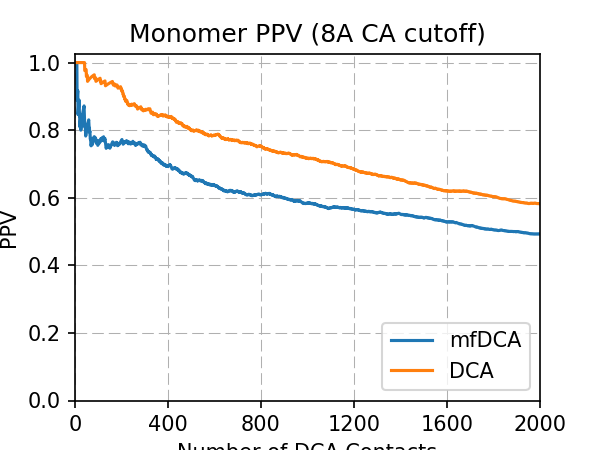

In [74]:
#Load PPV calclulation
mf_ppv_file = "./mfDCA/ppv_monomer_8A_mf.dat"
plm_ppv_file = "./plmDCA/ppv_mon_8A_plm.dat"
#plm2_ppv_file = "./plmDCA/ppv_mon_8A_plm.dat"
#plm_ppv_file = "./plmDCA/ppv_mon_8A_plm_di.dat"

mf_pairs, ppv = np.loadtxt(mf_ppv_file, unpack=True)
plm_pairs, ppv2 = np.loadtxt(plm_ppv_file, unpack=True)

#PPV Calculation
fig = plt.figure(figsize=(4,3), dpi=150)
plt.plot(mf_pairs, ppv, label="mfDCA")
plt.plot(plm_pairs,ppv2, label="DCA")

plt.xlim(0,2000)
plt.xticks(np.linspace(0,2000, num=6))
plt.yticks(np.linspace(0,1, num=6))
plt.title('Monomer PPV (8A CA cutoff)')
plt.xlabel("Number of DCA Contacts")
plt.ylabel("PPV")
plt.grid(linestyle="--", linewidth=0.5)
plt.legend(loc="lower right")

In [ ]:
# #mf_ppv_file12 = "./mfDCA/ppv_monomer_12A_mf.dat"
# plm_ppv_file12 = "./plmDCA/ppv_mon_plm_12A.dat"

# #Files for ppv
# #mf_pairs, ppv = np.loadtxt(mf_ppv_file12, unpack=True)
# plm_pairs12, ppv12 = np.loadtxt(plm_ppv_file12, unpack=True)

# #PPV Calculation
# fig = plt.figure(figsize=(4,3), dpi=150)
# #plt.plot(mf_pairs, ppv, label="mfDCA")
# plt.plot(plm_pairs12,ppv12, label="plmDCA 12A", c="orange")
# # plt.plot(plm_pairs,ppv2, label="plmDCA 8A")

# plt.xlim(0,2000)
# plt.yticks(np.linspace(0,1, num=6))
# plt.title('Monomer PPV (12A CA cutoff)')
# plt.xlabel("Number of DCA Contacts")
# plt.ylabel("PPV")
# plt.grid(linestyle="--", linewidth=0.5)
# plt.legend(loc="lower right")

## FN Histograms

[Back to Overview](#Overview)

In [ ]:
# x1,x2,null_fn = np.loadtxt("./plmDCA/plm-code/null_model/null_ranked.fn", unpack=True)
# y1,y2,plm_fn = np.loadtxt("./plmDCA/actinf150_ranked_plm.fn", unpack=True)

# fig = plt.figure(figsize=(6,5), dpi=100)
# null_hist = plt.hist(null_fn, bins=100, label="null model", log=True)
# normal_hist = plt.hist(plm_fn, bins=100, label="normal model", alpha=0.6, log=True)

# plt.title("FN Distribution")
# plt.xlabel("FN")
# plt.ylabel("Normalized Counts")
# plt.legend(loc="upper right")

#fn_cutoff = 0.1
#top_contacts = sum(normal_hist[0][(normal_hist[1]>fn_cutoff)[0:100]])
#print "Top number of contacts: %d" % top_contacts

# Solvent Accessible Surface Area Actin DCA contacts

[Back to Overview](#Overview)

In [ ]:
# #sasa_dca_file = 'plmDCA/sasa/top2000_plm_sasa.contacts'
# #sasa_dca_file = 'dca12A_dimer_2k_sasa.contacts'
# sasa_dca_file = 'cf_actinf150_sasa.txt'
# #sasa_dca_file = 'plmDCA/cluster_filtered/cf1_actinf150_top2k_sasa_plm.txt'
# sasa_i, sasa_j = np.loadtxt(sasa_dca_file, unpack=True)

# N = 100
# S =100
# fig = plt.figure(figsize=(10,9), dpi=100)
# #PDB Plots
# plt.scatter(pdb_mon_pair_i, pdb_mon_pair_j, marker='s', label="PDB Monomer")
# plt.scatter(pdb_inter_pair_i, pdb_inter_pair_j, marker='s', alpha=0.3, label="PDB Interfacial")
# #DCA Plots
# #plt.scatter(plm_pair_i[0:N], plm_pair_j[0:N], c='black', marker='o', alpha=1, label="Top %d DCA" % N)
# plt.scatter(sasa_i[0:S], sasa_j[0:S], c='firebrick', alpha=0.8, label="SASA DCA")

# plt.xlim(0,376)
# plt.xticks(np.linspace(0,375, num=6))
# plt.ylim(0,376)
# plt.yticks(np.linspace(0,375, num=6))
# plt.xlabel("residue i")
# plt.ylabel("residue j")
# plt.title("SASA-filtered DCA contact (Top %d)" % S)
# plt.grid(linestyle='--', linewidth=0.4)
# plt.legend(loc="lower right")

[Back to Overview](#Overview)

# Homologous Actin DCA

## HSP70 DCA

[Back to Overview](#Overview)

In [57]:
#Files for loading
plmDCA_file = "./plmDCA/cytoplasm/from_actin-actin_subseq/cyt_mapped_plm.fn"
rios = "../hsp70/delosRiosData/top624_mapped.fn"
hsp70_dca = "../hsp70/plmdca/hsp70_swiss_mapped.fn"
# hsp70_dca = "../hsp70/hsp_actin/hsp_dca_aligned.contacts"


#Files for hsp70 PDB contacts
hsp_monomer = "../hsp70/sbm/dimer/pdb_monomer_8A.contacts"
hsp_interface = "../hsp70/sbm/dimer/pdb_interfacial_8A.contacts"
# pdb_mapped_file = "../hsp70/hsp_actin/hsp2actin_pdb_mapped.contacts"
pdb_mapped_file = "../hsp70/hsp_actin/temp2"

#Load DCA pairs and DI or FN
plm_pair_i, plm_pair_j = np.loadtxt(hsp70_dca, usecols=(0,1), unpack=True)
rios_i, rios_j = np.loadtxt(rios, usecols=(0,1), unpack=True)

#Load PDB contacts
hsp_mon_pair_i, hsp_mon_pair_j = np.loadtxt(hsp_monomer, usecols=(1,3), unpack=True)
hsp_inter_pair_i, hsp_inter_pair_j = np.loadtxt(hsp_interface, usecols=(1,3), unpack=True)
pdb_mapped_i, pdb_mapped_j = np.loadtxt(pdb_mapped_file, unpack=True)

N = 500
hover = HoverTool(tooltips=[("Res i, Res j", "$x{0}, $y{0}")])
TOOLS="crosshair,pan,wheel_zoom,reset,save,box_select"
p5 = figure(title=("HSP70 DCA top %d" % N), 
            width=846, plot_height=600, tools=[TOOLS, hover])
p5.background_fill_color = "beige"
p5.background_fill_alpha = 0.5
p5.xaxis.major_label_orientation = np.pi/3

p5.square(pdb_mon_pair_i, pdb_mon_pair_j, 
          legend="Actin PDB Monomer", alpha=0.5)
p5.square(pdb_inter_pair_i, pdb_inter_pair_j, 
          legend="Actin PDB Interface", color="orange", alpha=0.4)
# p5.square(pdb_mapped_i, pdb_mapped_j, 
#           legend="HSP70 mapped", color="violet", alpha=0.6)
p5.square(hsp_mon_pair_i, hsp_mon_pair_j, 
          legend="HSP70 (DnaK) PDB Monomer", color="navy", alpha=0.3)
p5.square(hsp_inter_pair_i, hsp_inter_pair_j, 
          legend="HSP70 (DnaK) PDB Dimer Contacts", color="green", alpha=0.5)
p5.scatter(plm_pair_i[0:N], plm_pair_j[0:N], 
          legend="HSP70 DCA", color="red", alpha=0.5)
p5.scatter(rios_j[0:N], rios_i[0:N], 
            legend="Delos Rios predictions", color="purple", alpha=0.5)
p5.legend.location = "bottom_right"
p5.legend.click_policy="hide"
output_notebook()
show(p5)


Loading BokehJS ...

## MreB DCA

[Back to Overview](#Overview)

In [64]:
#Filename for DCA contacts
mreb_file = "../mreb/plmdca/mreb_single/mamk_mapped.fn"    #7000 sequences
mreb_file2 = "../mreb/plmdca/mreb_combined/mamk_mapped.fn"

#Bacterial Actin PDB File
mon_pdb = "../mreb/sbm/mamk/pdb_monomer_8A.contacts"
int_pdb = "../mreb/sbm/mamk/pdb_interfacial_8A.contacts"
mon_pair_i, mon_pair_j = np.loadtxt(mon_pdb, usecols=(1,3), unpack=True)
int_pair_i, int_pair_j = np.loadtxt(int_pdb, usecols=(1,3), unpack=True)

#Load DCA pairs and DI or FN
mreb_pair_i, mreb_pair_j, mreb_fn = np.loadtxt(mreb_file, usecols=(0,1,2), unpack=True)
mreb_pair_i2, mreb_pair_j2, mreb_fn2 = np.loadtxt(mreb_file2, usecols=(0,1,2), unpack=True)

#Plots
N=900
hover = HoverTool(tooltips=[("Res i, Res j", "$x{0}, $y{0}")])
TOOLS="crosshair,pan,wheel_zoom,reset,save,box_select"
p = figure(title=("MREB DCA Top %d" % N), 
           width=846, plot_height=600, tools=[TOOLS, hover])

p.background_fill_color = "beige"
p.background_fill_alpha = 0.5

# p.square(pdb_mon_pair_i, pdb_mon_pair_j, 
#          legend="Actin PDB Monomer", alpha=0.2)
# p.square(pdb_inter_pair_i, pdb_inter_pair_j, 
#          legend="Actin PDB Interface", color="orange", alpha=0.5)
p.square(mon_pair_i, mon_pair_j, 
         legend="MamK (MreB) PDB Monomer" , color="teal", alpha=0.7)
p.square(int_pair_i, int_pair_j, 
         legend="MamK (MreB) PDB Interface", color="coral", alpha=0.5)
p.scatter(mreb_pair_i[0:N], mreb_pair_j[0:N], 
          legend="MREB DCA", color="firebrick", alpha=0.7)
# p.scatter(mreb_pair_i2[0:N], mreb_pair_j2[0:N], 
#           legend="MREBc DCA", color="firebrick", alpha=0.7)
p.legend.location = "bottom_right"
p.legend.click_policy="hide"
output_notebook()
show(p)


Loading BokehJS ...

In [11]:
#Filename for DCA contacts
hexokinase = "../hexokinase/plm_dca/hexokinase_mapped.di"

#Load DCA pairs and DI or FN
hex_pair_i, hex_pair_j = np.loadtxt(hexokinase, usecols=(0,1), unpack=True)

#Plots
N=500
hover = HoverTool(tooltips=[("Res i, Res j", "$x{0}, $y{0}")])
TOOLS="crosshair,pan,wheel_zoom,reset,save,box_select"
ph = figure(title=("MREB DCA Top %d" % N), 
           width=846, plot_height=600, tools=[TOOLS, hover])

ph.background_fill_color = "beige"
ph.background_fill_alpha = 0.5

ph.square(pdb_mon_pair_i, pdb_mon_pair_j, 
         legend="Actin PDB Monomer", alpha=0.2)
ph.square(pdb_inter_pair_i, pdb_inter_pair_j, 
         legend="Actin PDB Interface", color="orange", alpha=0.5)
ph.scatter(hex_pair_i[0:N], hex_pair_j[0:N], 
          legend="Hexo", color="firebrick", alpha=0.7)
# p.scatter(mreb_pair_i2[0:N], mreb_pair_j2[0:N], 
#           legend="MREBc DCA", color="firebrick", alpha=0.7)
ph.legend.location = "bottom_right"
ph.legend.click_policy="hide"
output_notebook()
show(ph)

Loading BokehJS ...

In [75]:
x1, x2, y1, y2 = -1.8, 1.8, -1.8, 1.8
c_real, c_imag = -0.62772, -.42193

In [80]:
def calculate_z_serial_purepython(maxiter, zs, cs):
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z*z + c
            n += 1
        output[i] = n
    return output

In [81]:
def calc_pure_python(desired_width, max_iterations):
    x_step = (float(x2-x1) / float(desired_width))
    y_step = (float(y2-y1) / float(desired_width))
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord > x2:
        x.append(xcoord)
        xcoord += x_step
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))
    print "Len of x:", len(x)
    print "Total elements:", len(zs)
    start_time = time.time()
    output = calculate_z_serial_purepython(max_iterations, zs, cs)
    end_time = time.time()
    secs = end_time - start_time
    print calculate_z_serial_purepython.func_name + " took", secs, "seconds"

In [ ]:
if __name__ == "__main__":
    calc_pure_python(desired_width=1000, max_iterations=300)